In [1]:
# !pip install tqdm
# !pip install torchvision
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib

# !cd ../full_data
torch.cuda.empty_cache()

In [4]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import tqdm
import json
# !{sys.executable} -m pip install opencv-python matplotlib
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [5]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [7]:
sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.94,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10000,  # Requires open-cv to run post-processing
)

In [88]:
def getFrontCutout(masks,image):
    frontMask = None
    if len(masks) == 0:
        return frontMask
    elif len(masks) == 1:
        frontMask = masks[0]
    else:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            frontMask = masks[1]
        else:
            frontMask = masks[0]
    x,y,w,h = frontMask['bbox']
    x,y,w,h = int(x), int(y), int(w), int(h)
    cutout = image[y:y+h, x:x+w]
    return cutout

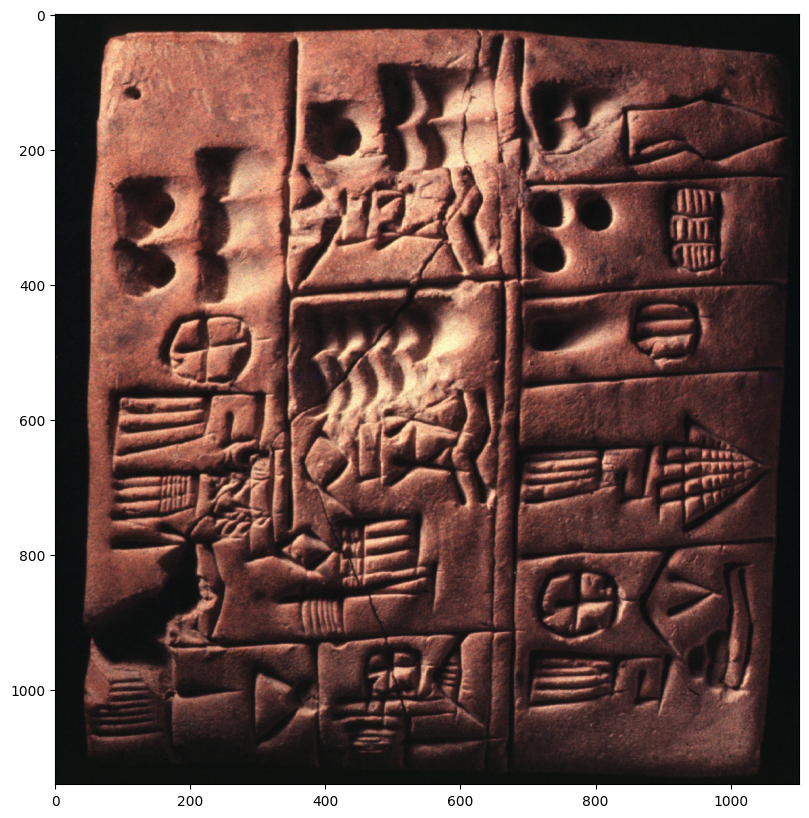

In [89]:
#demo image
image = cv2.imread("../full_data/images/P003499.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

7


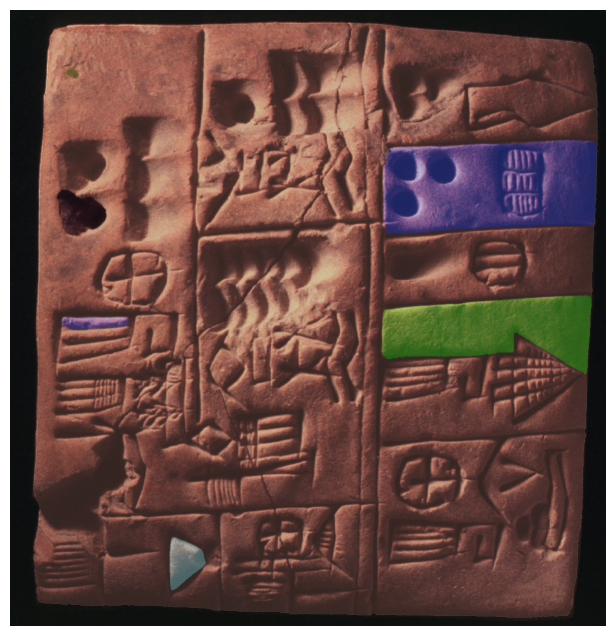

In [90]:
#demo image largest masks
masks = mask_generator.generate(image)
print(len(masks))
masks = sorted(masks, key = lambda d: d['area'], reverse = True )
plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

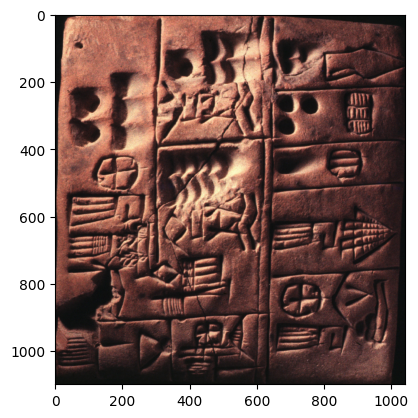

In [91]:
#demo image cutout
x,y,w,h = masks[1]['bbox']
cutout = getFrontCutout(masks,image)
plt.imshow(cutout)

In [92]:
# # print(train_ids[6618:6657])

# pid = train_ids[6709]
# image_name = "P"+ str(pid).zfill(6)+".jpg"
# image = cv2.imread("train_images_new/"+image_name)
# plt.imshow(image)

In [93]:
#NEW LOGIC

import json
with open ("train_ids.json", 'r') as f:
    train_ids = json.load(f)
with open ("val_ids.json", 'r') as f:
    val_ids = json.load(f)
print(len(train_ids),len(val_ids))

problem_images_val = []
problem_images_train = []

max_dim_hor = (2200, 2700)
max_dim_vert = (2700,2200)
min_dim = 600


def getFrontCutout(masks,image):
    frontMask = None
    if len(masks) == 0:
        return frontMask
    elif len(masks) == 1:
        frontMask = masks[0]
    else:
        if masks[0]['bbox'][0] <=5 and masks[0]['bbox'][1] <=5:
            frontMask = masks[1]
        else:
            frontMask = masks[0]
    x,y,w,h = frontMask['bbox']
    x,y,w,h = int(x), int(y), int(w), int(h)
    cutout = image[y:y+h, x:x+w]
    return cutout



12527 1283


In [94]:
# remaining val images

import os

remaining_val = []
for pid in val_ids:
    image_name = "P"+ str(pid).zfill(6)+".jpg"
    if not os.path.isfile("val_images/"+image_name):
        remaining_val.append(pid)

print(len(val_ids))
print(len(remaining_val))

1283
152


In [ ]:
for idx, pid in tqdm.tqdm(enumerate(train_ids[:20])):
    try:
        image_name = "P"+ str(pid).zfill(6)+".jpg"
        
        image = cv2.imread("../full_data/images/"+image_name)
        width = image.shape[1]
        height = image.shape[0]
        
        # if image resolution is too low use it as it is
        if height<=min_dim and width<=min_dim:
#             print("Using full image")
#             cv2.imwrite("train_images_new/"+image_name, image)
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image)
        cutout = getFrontCutout(masks, image)
        if cutout is None:
            print("Problem Image:", pid)
            problem_images_train.append(pid)
#             cv2.imwrite("train_images_new/"+image_name, image)
            continue
        
        cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)
#         cv2.imwrite("train_images_new/"+image_name, cutout)

    except:
        print("Exception occured", pid)
        print(image_name, width, height)
        problem_images_train.append(pid)
#         cv2.imwrite("train_images_new/"+image_name, image)
    
#     if idx%100==0:
#         with open ("problem_images_train.json", 'w') as f:
#             json.dump(problem_images_train, f)

1it [00:01,  1.23s/it]

Exception occured 423451
P423451.jpg 4297 5172


2it [00:02,  1.28s/it]

Exception occured 236197
P236197.jpg 4816 7713


3it [00:03,  1.33s/it]

Exception occured 236785
P236785.jpg 4860 9228


4it [00:05,  1.23s/it]

Exception occured 427810
P427810.jpg 3344 5179


5it [00:06,  1.34s/it]

Exception occured 236339
P236339.jpg 5625 9412


6it [00:08,  1.38s/it]

Exception occured 236849
P236849.jpg 5482 9306


7it [00:09,  1.33s/it]

Exception occured 423447
P423447.jpg 5312 6193


8it [00:10,  1.30s/it]

Exception occured 236613
P236613.jpg 4848 7108


9it [00:11,  1.31s/it]

Exception occured 431691
P431691.jpg 4592 10440


10it [00:12,  1.23s/it]

Exception occured 428510
P428510.jpg 4213 4666


11it [00:14,  1.23s/it]

Exception occured 236225
P236225.jpg 4816 6731


12it [00:15,  1.22s/it]

Exception occured 236804
P236804.jpg 4816 6780


13it [00:16,  1.25s/it]

Exception occured 236673
P236673.jpg 4822 7987


14it [00:17,  1.23s/it]

Exception occured 236345
P236345.jpg 4996 6495


15it [00:18,  1.23s/it]

Exception occured 236106
P236106.jpg 4816 6997


16it [00:20,  1.23s/it]

Exception occured 236017
P236017.jpg 5236 6831


17it [00:21,  1.32s/it]

Exception occured 236778
P236778.jpg 5248 10113


18it [00:22,  1.23s/it]

Exception occured 428544
P428544.jpg 3493 4460


In [53]:
# Fix low resolution images in the val set
for idx, pid in tqdm.tqdm(enumerate(val_ids)):
    image_name = "P"+ str(pid).zfill(6)+".jpg"

    image = cv2.imread("../full_data/images/"+image_name)
    width = image.shape[1]
    height = image.shape[0]

    if height<=min_dim and width<=min_dim:
        cv2.imwrite("val_images/"+image_name, image)

229it [00:06, 34.50it/s] 


KeyboardInterrupt: 

In [95]:
#handle problem images for both train and val


def resizeImage(image):
    
    while image.shape[0]/2000 > 1 or image.shape[1]/2000 > 1:
        dim = (int(image.shape[0]/2), int(image.shape[1]/2))
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return image 
    
    
    

with open ("problem_images.json", 'r') as f:
    problem_ids = json.load(f)

for idx, pid in tqdm.tqdm(enumerate(remaining_val)):
    try:
        image_name = "P"+ str(pid).zfill(6)+".jpg"
        
        image = cv2.imread("../full_data/images/"+image_name)
        
        
        image = resizeImage(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image)
        cutout = getFrontCutout(masks, image)
        
        cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)
#         plt.imshow(cutout)
        cv2.imwrite("val_images/"+image_name, cutout)

    except:
        print("Exception occured", pid)
        print(image_name, width, height)
    
    


152it [10:37,  4.19s/it]


plt.figure(figsize=(8,8))
plt.imshow(image)
show_anns(masks[1:2])
plt.axis('off')
plt.show() 

In [96]:
# # OLD LOGIC:
# for idx, pid in enumerate(train_ids):
#     try:
#         image_name = "P"+ str(pid).zfill(6)+".jpg"
#         image = cv2.imread("../full_data/images/"+image_name)
#         image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
#         cv2.imwrite("../full_data/images/"+image_name, image, [cv2.IMWRITE_PNG_COMPRESSION, 9])
#         image = cv2.imread("../full_data/images/"+image_name)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         masks = mask_generator.generate(image)
#         cutout = getFrontCutout(masks, image)
#         if cutout is None:
#             print("Problem Image:", pid)
#             problem_images_train.append(pid)
#             continue
#         cutout = cv2.cvtColor(cutout, cv2. COLOR_BGR2RGB)
# #         plt.imshow(cutout)
#         cv2.imwrite("train_images/"+image_name, cutout)
#     except:
#         print("in except", pid)
#         problem_images_train.append(pid)
#     if idx%10==0:
#         print(idx)
# #         sys.exit()

In [97]:
# OLD LOGIC: attempt at doing in a batched manner
# from segment_anything.utils.transforms import ResizeLongestSide
# resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

# def prepare_image(image, transform, device):
#     image = transform.apply_image(image)
#     image = torch.as_tensor(image, device=device.device) 
#     return image.permute(2, 0, 1).contiguous()

# def prepare_batched_input(batch):
#     batched_input = []
#     for pid in batch:
#         image_name = "P"+ str(pid).zfill(6)+".jpg"
#         image = cv2.imread("../full_data/images/"+image_name)
#         image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
#         cv2.imwrite("../full_data/images/"+image_name, image, [cv2.IMWRITE_PNG_COMPRESSION, 9])
#         image = cv2.imread("../full_data/images/"+image_name)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         batched_input.append({
#             'image': prepare_image(image1, resize_transform, sam),
#             'original_size': image1.shape[:2]
#         })
#     return batched_input

# total_images = len(train_ids)
